# Annual temperature anomalies relative to the pre-industrial period

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px

from statsmodels.nonparametric.smoothers_lowess import lowess

## EDA


### Reading the Data and creating Time Series


In [8]:
db = pd.read_csv("temperature-anomaly.csv")
db = db[["Year","Global average temperature anomaly relative to 1861-1890","Lower bound of the annual temperature anomaly (95% confidence interval)","Upper bound of the annual temperature anomaly (95% confidence interval)"]]
db = db.rename(columns={
    "Global average temperature anomaly relative to 1861-1890" : "Anomaly",
    "Lower bound of the annual temperature anomaly (95% confidence interval)" : "Lower Bound",
    "Upper bound of the annual temperature anomaly (95% confidence interval)" : "Upper Bound"
})
print(db.head())

   Year   Anomaly  Lower Bound  Upper Bound
0  1850 -0.055414    -0.226959     0.116131
1  1851  0.128948    -0.049570     0.307466
2  1852  0.132899    -0.047085     0.312882
3  1853  0.091943    -0.067712     0.251598
4  1854  0.070777    -0.070414     0.211968


In [9]:
dates = pd.date_range(start='1850', periods=len(db), freq='YE')
mytimeseries = pd.DataFrame(db.iloc[:, 1:].values, index=dates, columns=db.columns[1:])

print("\nTime series info:")
print(mytimeseries.info())
print(mytimeseries.head())


Time series info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 1850-12-31 to 2025-12-31
Freq: YE-DEC
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Anomaly      176 non-null    float64
 1   Lower Bound  176 non-null    float64
 2   Upper Bound  176 non-null    float64
dtypes: float64(3)
memory usage: 5.5 KB
None
             Anomaly  Lower Bound  Upper Bound
1850-12-31 -0.055414    -0.226959     0.116131
1851-12-31  0.128948    -0.049570     0.307466
1852-12-31  0.132899    -0.047085     0.312882
1853-12-31  0.091943    -0.067712     0.251598
1854-12-31  0.070777    -0.070414     0.211968


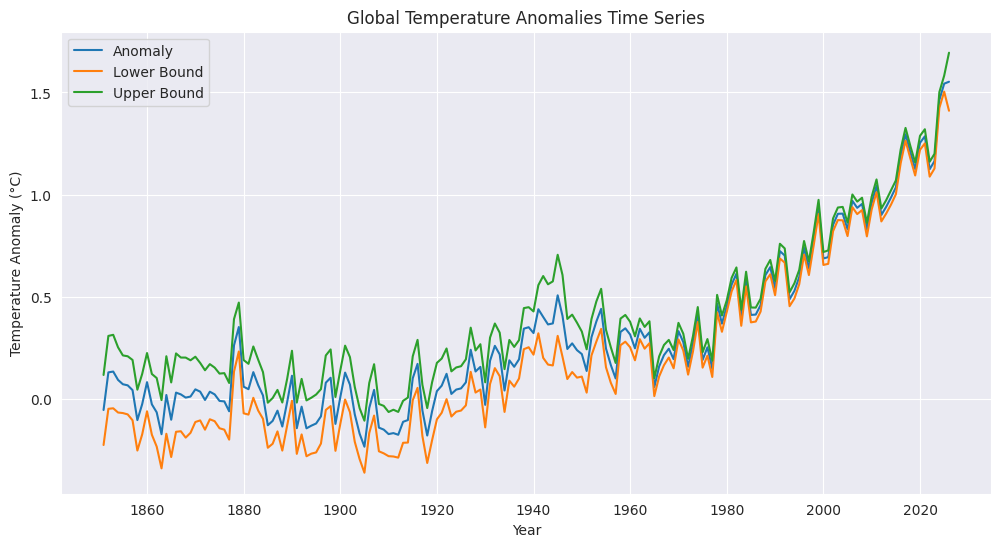

In [11]:
plt.figure(figsize=(12, 6))
for col in mytimeseries.columns:
    plt.plot(mytimeseries.index, mytimeseries[col], label=col)

plt.title("Global Temperature Anomalies Time Series")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.grid(True)
plt.legend()
plt.show()

For this analysis, the primary focus is on the global average temperature anomaly. While the dataset provides upper and lower bounds to indicate uncertainty, these values are not essential for understanding the overall trend. The average anomaly alone captures how much the Earth's surface temperature has deviated from pre-industrial levels each year.

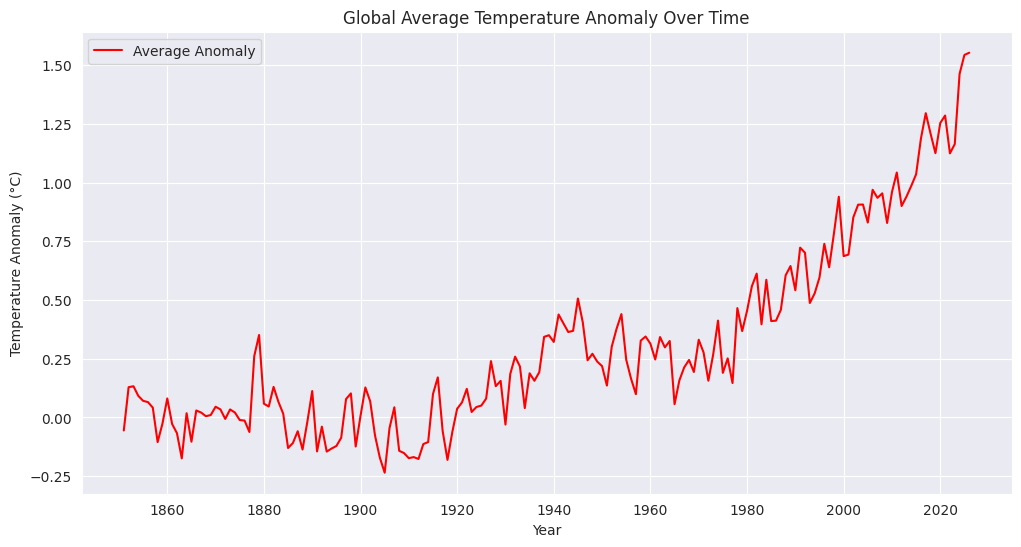

In [12]:
average_anomaly = mytimeseries['Anomaly']


plt.figure(figsize=(12, 6))
plt.plot(average_anomaly.index, average_anomaly, color='red', label='Average Anomaly')
plt.title("Global Average Temperature Anomaly Over Time")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.grid(True)
plt.legend()
plt.show()

By concentrating on the average, we can clearly observe the long-term warming trend without the distraction of additional columns. This simplification makes the analysis cleaner, easier to interpret, and directly highlights the magnitude of global temperature changes over time.

### Descriptive Analysis of the Time Series

The series shows a clear upward trend over the past 170+ years, indicating a gradual increase in global temperatures relative to
   pre-industrial levels.

Although there is a general warming trend, the anomalies fluctuate from year to year, with some years being cooler or warmer than the previous year.

The early 20th century shows relatively small deviations, while the late 20th and early 21st centuries exhibit larger positive anomalies, with record highs in recent decades.

The warming trend is gradual over decades, rather than abrupt jumps, although occasional short-term dips are visible due to natural variability.


### Time Series Components